# Does everything to run entropy and creates slurm files to submit

## Run entropy with all diploid likelihoods from bcftools and all tetraploid likelihoods from ebg

Goal is 4 chains k=2-7.

**Creates mpgl file from PL in vcf and post-ebg**. 
Use CHDO.diseq.long-PL.txt

**full pntest_mean and mpgl all file taken from 6entropy_CHDO_diploidAll**  
Rename pntest_mean_final_snps.recode.txt to pntest_mean_diploidAll.txt  
Rename final_snps.recode.mpgl to mpgl_diploidAll.txt


In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [3]:
root = '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall'

In [4]:
cd $root

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall


### Create mgpl & pntest files with associated dir   

Uses custom R script to do so

In [5]:
ent_dir =os.path.join(root,'entropy_ebgAll')
assert ent_dir

In [6]:
!mkdir $ent_dir

mkdir: cannot create directory ‘/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll’: File exists


In [7]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll


### move ebg PL txt, and Pop_ID to ent dir, extract PL data   

In [8]:
%load_ext rpy2.ipython

In [10]:
%%R
require(readr)
library(data.table)
require(MASS)
require(LEA)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/')

R[write to console]: Loading required package: LEA



In [12]:
%%R 
#read in data
PL_4 <- data.frame(fread('CHDO4.diseq-PL.txt',header=F,sep='\t'))
PL_6 <- data.frame(fread('CHDO6.diseq-PL.txt',header=F,sep='\t'))

pntest_mean_2 <- data.frame(fread('pntest_mean_diploidAll.txt'))
mpgl_2 <- data.frame(fread('mpgl_diploidAll.txt',header=FALSE),row.names=1)

Pop_ID_OG <- read.csv('Pop_ID.csv')
Pop_ID_4 <- read.csv('Pop_ID_4.csv')
Pop_ID_6 <- read.csv('Pop_ID_6.csv')

In [14]:
%%R
# REMOVE LAST COLUMN of PL_4/6 for some reason
PL_4 <- PL_4[,-c(ncol(PL_4))]
PL_6 <- PL_6[,-c(ncol(PL_6))]

In [15]:
%%R
print(dim(Pop_ID_OG))
print(dim(Pop_ID_4))

print(dim(pntest_mean_2))
print(pntest_mean_2[1:5,1:5])
print(dim(mpgl_2))
print(mpgl_2[1:5,1:5])
print(dim(PL_4))
print(PL_4[1:5,(ncol(PL_4)-5):ncol(PL_4)])
print(dim(PL_6))
print(PL_6[1:5,(ncol(PL_6)-5):ncol(PL_6)])

[1] 272   6
[1] 142   6
[1] 23425   272
       V1      V2      V3      V4      V5
1 0.99685 0.99998      NA      NA 1.79924
2      NA      NA 0.11182      NA 0.00013
3 0.00000 0.00000      NA      NA 0.03065
4 0.11182 1.00198      NA 0.00397 0.50000
5 0.96935      NA      NA 1.00000 0.20081
[1] 23425   816
                       V2 V3  V4 V5 V6
dDocent_Contig_794:58  25  0  73 46  0
dDocent_Contig_860:5    0  0   0  0  0
dDocent_Contig_1448:8   0 54 194  0 75
dDocent_Contig_2012:5   0  9  81 48  0
dDocent_Contig_2169:59 15  0  99  0  0
[1] 23425   142
                                         V137
1     21.9465,3.05883,3.36601,14.1468,62.4969
2    0.100382,16.4519,36.7373,65.9538,196.981
3 4.51701e-08,79.8293,280.463,631.283,2102.91
4       6.5309,1.1653,18.8469,49.6475,157.049
5   0.0404752,20.3326,48.6524,92.7024,240.624
                                         V138
1     41.5741,6.23689,1.96209,9.01071,53.0755
2   0.0566408,18.9335,37.6057,65.2427,210.351
3 6.89313e-10,97.9937,234.14

In [16]:
%%R
#converts pl to mpgl format
mpgl_4 <- apply(PL_4, c(1,2), function(df) gsub(',',' ',df,fixed=TRUE))
mpgl_6 <- apply(PL_6, c(1,2), function(df) gsub(',',' ',df,fixed=TRUE))

In [17]:
%%R
#check pl and mggl
print(PL_4[1:5,1:5])
print(mpgl_4[1:5,1:5])
print(PL_6[1:5,1:5])
print(mpgl_6[1:5,1:5])

                                         V1
1    8.8395,7.43673,6.72775,6.31089,6.15002
2  0.0212101,23.1656,43.232,73.9566,254.217
3 0.0112166,25.9792,42.5789,66.7387,155.891
4  0.00413763,30.2168,60.196,107.094,291.54
5   0.547619,10.5448,16.1088,22.5074,38.347
                                          V2
1      22.6142,10.52,6.60117,4.71218,4.56934
2    0.0148725,24.6767,49.2159,87.26,308.362
3 0.00590701,28.6896,51.5399,85.7407,212.839
4 0.00390291,30.4683,63.1237,114.237,312.522
5    0.64437,9.64995,16.0034,23.6431,41.2868
                                         V3
1   22.2045,10.5732,6.81907,4.85891,4.29854
2 0.00328389,31.2178,64.1566,116.63,434.491
3   0.042871,20.4697,30.9036,44.473,86.8122
4 0.00844717,27.1233,54.277,96.2807,257.982
5  0.430071,10.9893,18.7529,28.7789,57.0211
                                           V4
1      3.47292,4.2931,8.12028,16.1605,45.3109
2    0.311321,12.4886,19.5387,27.7767,54.0864
3 8.99091e-06,56.8398,119.147,219.446,622.839
4     0.16533,14.6

In [18]:
%%R
rownames(mpgl_4) <- rownames(mpgl_2)
print(dim(mpgl_4))
fwrite(mpgl_4,'mpgl_4.txt',quote=F,col.names = F,sep = ' ') 

rownames(mpgl_6) <- rownames(mpgl_2)
print(dim(mpgl_6))
fwrite(mpgl_6,'mpgl_6.txt',quote=F,col.names = F,sep = ' ') 

[1] 23425   142


R[write to console]: x being coerced from class: matrix to data.table



[1] 23425    30


R[write to console]: x being coerced from class: matrix to data.table



In [19]:
%%R
### pntest_mean ploidy###
mean_pl <- function(GP){
  gps <- as.numeric(unlist(strsplit(as.character(GP),split = ',')))
  ploidy <- length(gps)-1
  if (sum(gps) == 0){
    mean <- 0
  }else{
    gps <- 10 ^ (gps/-10)
    mean <- sum(gps*(0:ploidy))/sum(gps)
    return(mean) 
  }
}

system.time(pntest_mean_4 <- apply(PL_4,1:2,mean_pl))
system.time(pntest_mean_6 <- apply(PL_6,1:2,mean_pl))

   user  system elapsed 
 21.442   0.474  21.910 


In [20]:
%%R 
rownames(pntest_mean_4) <- rownames(mpgl_2)
print(dim(pntest_mean_4))
fwrite(pntest_mean_4,'pntest_mean_4.txt',quote=F,sep = ' ')

rownames(pntest_mean_6) <- rownames(mpgl_2)
print(dim(pntest_mean_6))
fwrite(pntest_mean_6,'pntest_mean_6.txt',quote=F,sep = ' ')

[1] 23425   142


R[write to console]: x being coerced from class: matrix to data.table



[1] 23425    30


R[write to console]: x being coerced from class: matrix to data.table



In [21]:
%%R
#make sure ploidy makes sense
print(apply(pntest_mean_4,2,function(df) range(df, na.rm=TRUE)))[1:5]
print(apply(pntest_mean_6,2,function(df) range(df, na.rm=TRUE)))[1:5]

               V1           V2           V3           V4           V5
[1,] 6.188708e-33 1.630047e-31 2.681637e-31 1.552387e-31 1.553102e-30
[2,] 4.000000e+00 3.999703e+00 3.998456e+00 3.999773e+00 4.000000e+00
              V6           V7           V8           V9          V10
[1,] 2.84905e-33 8.160185e-33 1.217026e-28 3.318945e-31 9.210856e-33
[2,] 4.00000e+00 4.000000e+00 3.997293e+00 3.998991e+00 3.999796e+00
              V11          V12          V13          V14          V15
[1,] 6.437244e-31 5.244451e-31 1.532498e-23 4.067242e-21 4.960209e-24
[2,] 3.999631e+00 3.997980e+00 3.999915e+00 3.999028e+00 3.999979e+00
              V16          V17          V18          V19          V20
[1,] 2.133045e-22 7.262732e-19 2.657052e-19 7.423351e-33 1.415468e-21
[2,] 3.999903e+00 4.000000e+00 4.000000e+00 4.000000e+00 3.999994e+00
              V21          V22          V23        V24          V25
[1,] 1.832736e-17 1.459822e-16 1.481836e-19 5.5386e-31 1.625175e-25
[2,] 3.999653e+00 4.000000e

In [23]:
%%R
print(dim(pntest_mean_4))
print(pntest_mean_4[1:5,1:4])

print(dim(pntest_mean_6))
print(pntest_mean_6[1:5,1:4])

[1] 23425   142
                                 V1           V2           V3           V4
dDocent_Contig_794:58  2.2774537794 2.9366124629 2.9703168753 7.531860e-01
dDocent_Contig_860:5   0.0049195071 0.0034306326 0.0007562429 8.364441e-02
dDocent_Contig_1448:8  0.0026350248 0.0013662345 0.0107063390 2.070239e-06
dDocent_Contig_2012:5  0.0009532173 0.0008987544 0.0019468825 4.070489e-02
dDocent_Contig_2169:59 0.1546320311 0.1718559046 0.1102634184 2.005849e-01
[1] 23425    30
                                 V1           V2           V3           V4
dDocent_Contig_794:58  4.106040e+00 2.230934e+00 3.3711540496 3.993496e+00
dDocent_Contig_860:5   2.295130e-04 1.868011e-03 0.0024826078 1.119280e-04
dDocent_Contig_1448:8  3.883119e-05 3.401933e-06 0.0002000351 8.446624e-05
dDocent_Contig_2012:5  1.742073e-04 1.501497e-02 0.0004489441 3.142043e-03
dDocent_Contig_2169:59 7.347011e-01 1.041872e+00 2.7545151209 5.604204e-01


## merge needed diploid, tetraploids, hexaploids to make new files 

In [25]:
%%R
Pop_ID_OG <- read.csv('Pop_ID.csv')
Pop_ID_4 <- read.csv('Pop_ID_4.csv')
Pop_ID_6 <- read.csv('Pop_ID_6.csv')

pntest_mean_2 <- data.frame(fread('pntest_mean_diploidAll.txt'))
mpgl_2 <- data.frame(fread('mpgl_diploidAll.txt',header=FALSE),row.names=1)

pntest_mean_4 <- data.frame(fread('pntest_mean_4.txt'))
mpgl_4 <- data.frame(fread('mpgl_4.txt',header=FALSE))

pntest_mean_6 <- data.frame(fread('pntest_mean_6.txt'))
mpgl_6 <- data.frame(fread('mpgl_6.txt',header=FALSE))



In [26]:
%%R
print(dim(Pop_ID_OG))
print(dim(pntest_mean_2))
print(dim(mpgl_2))

print(dim(Pop_ID_4))
print(dim(pntest_mean_4))
print(dim(mpgl_4))

print(dim(Pop_ID_6))
print(dim(pntest_mean_6))
print(dim(mpgl_6))

[1] 272   6
[1] 23425   272
[1] 23425   816
[1] 142   6
[1] 23425   142
[1] 23425   710
[1] 30  6
[1] 23425    30
[1] 23425   210


In [27]:
%%R
#extract only diploids for mpgl 
#first make a header for mpgl_2 so can select the right indv
names3 <- rep(Pop_ID_OG$All,each=3)
names(mpgl_2) <- names3
only2_names <- Pop_ID_OG$All[which(Pop_ID_OG$Ploidy == 2)]
index_mpgl2 <- which(names(mpgl_2) %in% only2_names)
mpgl_2only <- mpgl_2[,index_mpgl2]

#only diploids for rest
pntest_mean_2only <- pntest_mean_2[,which(Pop_ID_OG$Ploidy == 2)]
Pop_ID_2only <- Pop_ID_OG[which(Pop_ID_OG$Ploidy == 2),]

In [28]:
%%R
print(dim(Pop_ID_2only))
print(dim(pntest_mean_2only))
print(dim(mpgl_2only))

[1] 100   6
[1] 23425   100
[1] 23425   300


In [29]:
%%R

pntest_mean_ebgAll <- cbind(pntest_mean_2only,pntest_mean_4,pntest_mean_6)


mpgl_ebgAll <- cbind(mpgl_2only,mpgl_4,mpgl_6)
Pop_ID_ebgAll <- rbind(Pop_ID_2only,Pop_ID_4,Pop_ID_6)


In [32]:
%%R
print(dim(Pop_ID_ebgAll))
print(dim(pntest_mean_ebgAll))
print(dim(mpgl_ebgAll))

#test right dim for mpgl
print((nrow(Pop_ID_2only)*3) + (nrow(Pop_ID_4)*5) + (nrow(Pop_ID_6)*7))

[1] 272   6
[1] 23425   272
[1] 23425  1220
[1] 1220


In [33]:
%%R
print(pntest_mean_ebgAll[1:5,1:5])

       V1      V2      V3      V4      V5
1 0.99685 0.99998      NA      NA 1.79924
2      NA      NA 0.11182      NA 0.00013
3 0.00000 0.00000      NA      NA 0.03065
4 0.11182 1.00198      NA 0.00397 0.50000
5 0.96935      NA      NA 1.00000 0.20081


In [34]:
%%R
print(rownames(mpgl_2)[1:10])
rownames(mpgl_ebgAll) <- rownames(mpgl_2)


 [1] "dDocent_Contig_794:58"  "dDocent_Contig_860:5"   "dDocent_Contig_1448:8" 
 [4] "dDocent_Contig_2012:5"  "dDocent_Contig_2169:59" "dDocent_Contig_2541:34"
 [7] "dDocent_Contig_2679:47" "dDocent_Contig_2762:47" "dDocent_Contig_2933:69"
[10] "dDocent_Contig_3152:79"


In [35]:
%%R
rownames(mpgl_ebgAll) <- rownames(mpgl_2)
fwrite(mpgl_ebgAll,'mpgl_ebgAll.txt',quote=F,col.names = F,row.names=TRUE,sep = ' ') 
#change pntest NAs to 0 
fwrite(pntest_mean_ebgAll,'pntest_mean_ebgAll.txt',na=0,col.names = F,sep = ' ') 
write.csv(Pop_ID_ebgAll,'Pop_ID_ebgAll.csv',row.names=F)

## Create ldak files in R: standardize by ploidy! 

see mixed_ploidy_PCA.Rmd

In [43]:
%%R
#read in data 
Pop_ID <- read.csv("Pop_ID_ebgAll.csv")
pntest_mean <- fread("pntest_mean_ebgAll.txt",header=F, data.table=F)

g <- t(pntest_mean)

###make sure all NA to 0 
#g[is.na(g)]<-0
print(length(which(is.na(g))))
print(dim(g))
g[1:5,1:5]

[1] 0
[1]   272 23425
      [,1]    [,2]    [,3]    [,4]    [,5]
V1 0.99685 0.00000 0.00000 0.11182 0.96935
V2 0.99998 0.00000 0.00000 1.00198 0.00000
V3 0.00000 0.11182 0.00000 0.00000 0.00000
V4 0.00000 0.00000 0.00000 0.00397 1.00000
V5 1.79924 0.00013 0.03065 0.50000 0.20081


In [44]:
%%R 

#test, convert 0 after scale 
g[which(g == 0)] <- NA
print(length(which(is.na(g))))

#### create pl_list ####

pl_list <- Pop_ID$Ploidy

#### get stats on g and ploidy ####

nind <- nrow(g)
nloci <- ncol(g)
n2_index <- which(pl_list == 2)
n4_index <- which(pl_list == 4)
n6_index <- which(pl_list == 6)

#### check distributions  / range ###
g2 <- g[n2_index,]
g4 <- g[n4_index,]
g6 <- g[n6_index,]




[1] 772087


In [47]:
%%R
#### create pl_list ####

pl_list <- Pop_ID$Ploidy

#### get stats on g and ploidy ####

nind <- nrow(g)
nloci <- ncol(g)
n2_index <- which(pl_list == 2)
n4_index <- which(pl_list == 4)
n6_index <- which(pl_list == 6)

#### check distributions  / range ###
g2 <- g[n2_index,]
g4 <- g[n4_index,]
g6 <- g[n6_index,]

#### scale withing ####
g2_scale <- scale(g2)
g4_scale <- scale(g4)
g6_scale <- scale(g6)

g_z <- rbind(g2_scale,g4_scale,g6_scale)

### if NAs
g_z[is.na(g_z)] <- 0

z_pca <- prcomp(as.matrix(g_z),scale. = F, center = F)
pve <- summary(z_pca)$importance[2,1:5]
print(summary(z_pca)$importance[2:3,1:5])

pca_df <- cbind(rbind(Pop_ID[n2_index,],Pop_ID[n4_index,],Pop_ID[n6_index,]),
                  z_pca$x[,1:5])

                           PC1     PC2     PC3     PC4     PC5
Proportion of Variance 0.05088 0.03453 0.02657 0.01970 0.01910
Cumulative Proportion  0.05088 0.08541 0.11198 0.13169 0.15079


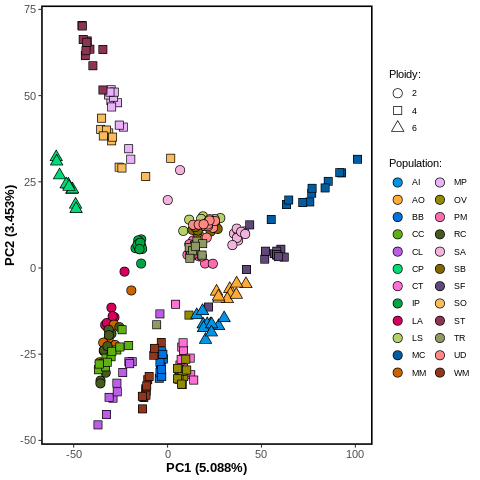

In [48]:
%%R
col24 <- c("#0094e6","#ffab35","#0072e1","#5fb111","#bb5de5","#00db79","#ff70d7","#00a543",
           "#d5005b","#b7d069","#005da2","#ca6300","#eab3f9","#928b00","#ff6cae","#46591e",
           "#f3b3dd","#816600","#604879","#fabb5d","#8d3353","#919962","#ff8885","#8f361c")

ggplot(data = pca_df, aes(x=PC1,y=PC2,
                          fill=Pop,shape=as.character(Ploidy))) + 
  geom_point(colour='black',size = 4) +
  xlab(paste("PC",1," (",pve[1]*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",pve[2]*100,"%)",sep=""))  +
  scale_fill_manual(name='Population:',values = col24) +
  scale_shape_manual(name='Ploidy:',values = c(21,22,24)) + 
  guides(fill = guide_legend(override.aes=list(pch=21))) +
  theme_bw() + 
  theme(#legend.position = 'none',
    axis.text = element_text(size=11), 
    axis.title = element_text(size = 13, colour="black",face = "bold",vjust = 1),
    panel.border = element_rect(size = 1.5, colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())

In [49]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(z_pca$x[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(z_pca$x[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(z_pca$x[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(z_pca$x[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(z_pca$x[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(z_pca$x[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(z_pca$x[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(z_pca$x[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(z_pca$x[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(z_pca$x[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=z_pca$x[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=z_pca$x[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=z_pca$x[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=z_pca$x[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=z_pca$x[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=z_pca$x[,1:5],grouping=k7$cluster,CV=TRUE)
#ldak8<-lda(x=z_pca$x[,1:5],grouping=k8$cluster,CV=TRUE)
#ldak9<-lda(x=z_pca$x[,1:5],grouping=k9$cluster,CV=TRUE)
#ldak10<-lda(x=z_pca$x[,1:5],grouping=k10$cluster,CV=TRUE)
#ldak11<-lda(x=z_pca$x[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [50]:
%%R
###### Create ploidy inds.txt ######
ploidy_inds <- data.frame(Ploidy=Pop_ID$Ploidy)
write.table(ploidy_inds,'ploidy_inds.txt',quote=F,row.names=F,col.names=F)

In [51]:
!head ploidy_inds.txt
!wc -l ploidy_inds.txt

2
2
2
2
2
2
2
2
2
2
272 ploidy_inds.txt


In [52]:
%%R
######### create entropy header ####

Pop_ID_list <- Pop_ID$All

Header <- data.frame(dims = NA,Pop_ID_list)

dim(pntest_mean)

df <- t(Header)
dims <- paste(dim(pntest_mean)[2],dim(pntest_mean)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [53]:
!head entropy_header.txt

272 23425                                                                                                                                                                                                                                                                               
CD2_IP_10 CD2_IP_11 CD2_IP_12 CD2_IP_1 CD2_IP_2 CD2_IP_3 CD2_IP_4 CD2_IP_5 CD2_IP_6 CD2_IP_7 CD2_IP_8 CD2_IP_9 CD2_LA_10 CD2_LA_11 CD2_LA_1 CD2_LA_2 CD2_LA_3 CD2_LA_6 CD2_LA_7 CD2_LA_8 CD2_LS_10 CD2_LS_11 CD2_LS_12 CD2_LS_1 CD2_LS_2 CD2_LS_3 CD2_LS_4 CD2_LS_5 CD2_LS_6 CD2_LS_7 CD2_LS_8 CD2_LS_9 CD2_MM_10 CD2_MM_11 CD2_MM_12 CD2_MM_1 CD2_MM_2 CD2_MM_3 CD2_MM_4 CD2_MM_5 CD2_MM_6 CD2_MM_7 CD2_MM_8 CD2_MM_9 CD2_PM_10 CD2_PM_11 CD2_PM_12 CD2_PM_1 CD2_PM_2 CD2_PM_3 CD2_PM_4 CD2_PM_5 CD2_PM_6 CD2_PM_7 CD2_PM_8 CD2_PM_9 CD2_RC_10 CD2_RC_11 CD2_RC_12 CD2_RC_1 CD2_RC_2 CD2_RC_3 CD2_RC_4 CD2_RC_5 CD2_RC_6 CD2_RC_7 CD2_RC_8 CD2_RC_9 CD2_SA_10 CD2_SA_11 CD2_SA_12 CD2_SA_1 CD2_SA_2 CD2_SA_3 CD2_SA_4 CD2_SA_6 CD2_SA_7 CD2_SA

In [54]:
!cat entropy_header.txt mpgl_ebgAll.txt > entropy.mpgl

In [55]:
!head entropy.mpgl

272 23425                                                                                                                                                                                                                                                                               
CD2_IP_10 CD2_IP_11 CD2_IP_12 CD2_IP_1 CD2_IP_2 CD2_IP_3 CD2_IP_4 CD2_IP_5 CD2_IP_6 CD2_IP_7 CD2_IP_8 CD2_IP_9 CD2_LA_10 CD2_LA_11 CD2_LA_1 CD2_LA_2 CD2_LA_3 CD2_LA_6 CD2_LA_7 CD2_LA_8 CD2_LS_10 CD2_LS_11 CD2_LS_12 CD2_LS_1 CD2_LS_2 CD2_LS_3 CD2_LS_4 CD2_LS_5 CD2_LS_6 CD2_LS_7 CD2_LS_8 CD2_LS_9 CD2_MM_10 CD2_MM_11 CD2_MM_12 CD2_MM_1 CD2_MM_2 CD2_MM_3 CD2_MM_4 CD2_MM_5 CD2_MM_6 CD2_MM_7 CD2_MM_8 CD2_MM_9 CD2_PM_10 CD2_PM_11 CD2_PM_12 CD2_PM_1 CD2_PM_2 CD2_PM_3 CD2_PM_4 CD2_PM_5 CD2_PM_6 CD2_PM_7 CD2_PM_8 CD2_PM_9 CD2_RC_10 CD2_RC_11 CD2_RC_12 CD2_RC_1 CD2_RC_2 CD2_RC_3 CD2_RC_4 CD2_RC_5 CD2_RC_6 CD2_RC_7 CD2_RC_8 CD2_RC_9 CD2_SA_10 CD2_SA_11 CD2_SA_12 CD2_SA_1 CD2_SA_2 CD2_SA_3 CD2_SA_4 CD2_SA_6 CD2_SA_7 CD2_SA

In [56]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll


In [57]:
!mkdir shdir

In [58]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '14-00:00:00' #time limit 14 days
cpus = 1 #to prevent hammering one node
mem_cpu = 16000
email = 'tfaske@nevada.unr.edu'

#entropy settings
ploidy = 'ploidy_inds.txt'
l = 60000
b = 10000
num_k = [2,3,4,5,6,7]
chains = 4

In [59]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,ploidy,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n ../%s -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,ploidy,l,b,k,k))
    

In [60]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,ploidy,l,b,num_k,chains)

In [61]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_entropy_k4_c3.sh',
 '/data/gp

In [62]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [63]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/home/tfaske/d/connie/ch2/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [64]:
np.set_printoptions(precision=8) # increases float print option
pd.set_option("precision", 8)

In [65]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll


In [66]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5']

In [67]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [68]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [69]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k3_c2.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt']

In [70]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 13807501.88
Effective number of parameters: 17657549.01
Model DIC: 31465050.89


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 12022145.53
Effective number of parameters: 45494710.63
Model DIC: 57516856.16


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 13806998.34
Effective number of parameters: 17817596.47
Model DIC: 31624594.81


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 12265292.10
Effective number of parameters: 30832929.84
Model DIC: 43098221.95


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 13123930.98
Effective number of parameters: 22520936.00
Model DIC: 35644866.98


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: sa

In [71]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,31465050.89,4
1,7,57516856.16,2
2,2,31624594.81,1
3,6,43098221.95,1
4,3,35644866.98,2


In [72]:
dic_df.to_csv('dic_list.csv')

In [73]:
dic_sum = dic_df.groupby('k').describe().DIC

In [74]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
2,4.0,3.16576840e+07,2.45624683e+05,31465050.89,3.15125254e+07,31576472.490,3.17216311e+07,32012740.06
4,4.0,3.57618628e+07,3.58511605e+05,35429820.34,3.55401633e+07,35682712.495,3.59044119e+07,36252205.69
3,4.0,3.60746566e+07,7.61726783e+05,35538847.16,3.56183620e+07,35784404.215,3.62406988e+07,37190970.69
5,4.0,3.90006150e+07,7.76504879e+05,38091362.69,3.84863162e+07,39119927.215,3.96342260e+07,39671242.81
6,4.0,4.23140627e+07,6.87043447e+05,41437936.83,4.20386559e+07,42360046.075,4.26354529e+07,43098221.95
7,4.0,5.13887688e+07,4.87712013e+06,45586502.67,4.96604276e+07,51225858.185,5.29541993e+07,57516856.16


In [75]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [76]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 272, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 272, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 272, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 272, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 272, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

In [77]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 272, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 272, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 272, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 272, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 272, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

### make slurm script to make gprob file

    use all k and chains to make gprob

In [78]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll


In [79]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,5,6,7]

In [80]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [81]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [82]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_gprob_k5.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_gprob_k6.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_ebgAll/shdir/run_gprob_k7.sh']

In [83]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [84]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

In [85]:
hdf5_files = []
for k in num_k:
    f = '../entropy_k' + str(k) + '_c*hdf5'
    hdf5_files.append(f)
hdf5_files

['../entropy_k2_c*hdf5',
 '../entropy_k3_c*hdf5',
 '../entropy_k4_c*hdf5',
 '../entropy_k5_c*hdf5',
 '../entropy_k6_c*hdf5',
 '../entropy_k7_c*hdf5']

In [86]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c*hdf5 ../entropy_k3_c*hdf5 ../entropy_k4_c*hdf5 ../entropy_k5_c*hdf5 ../entropy_k6_c*hdf5 ../entropy_k7_c*hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [87]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [88]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [89]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 
    cd /data/gpfs/home/tfaske/d/milkweed/entropy
    source activate entropy
    sbatch run_gprob.sh

In [ ]:
#gprobs
#!$estpost *k2*.hdf5 -p gprob -s 0 -o gprob2.txt

#!$estpost *k3*.hdf5 -p gprob -s 0 -o gprob3.txt

#!$estpost *k4*.hdf5 -p gprob -s 0 -o gprob4.txt

#!$estpost *k5*.hdf5 -p gprob -s 0 -o gprob5.txt